# Block 3
We have a detector that measures hit positions in an $(x; y)$ plane in the range $([-1,1],[-1,1])$ and
the energy (E) in the range $[0,10]$, in arbitrary units.

Using such a detector, we perform an experiment with the aim of statistically establishing
the detection of events of type signal, in the presence of events of type background. Signal and
background events have different p.d.f.'s for x, y and E. The result of our experiment is provided
in the input file data `On.txt`.

In an independent experiment, using the same detector, we measure in conditions such that only
background events are collected. We measure for 3 times longer and therefore we expect 3 times
more background events in the Off data sample than in the On data sample. The results are
provided in the input file data `Off.txt`.

In order to study the best way to separate signal from background using the spatial information
we use two independent simulated samples (train and test) for signal and background events, re-
spectively. Those are train `signal.txt`, `train bkg.txt`, `test signal.txt` and `test bkg.txt`.

The joint p.d.f.'s for the spatial coordinates for signal and background events are, respectively:

$$
f_s(
$$
with $a = b = 6$ and $c = -5$, for signal, and
$$
f_b(
$$
with $r = \sqrt{x^2 + y^2}$, $r0 = 0.6$ and $\sigma_r = 0.4$, for background.

In addition, we know that the spectrum of signal and background events have, respectively, the following shapes:
$$
\frac{dN_S}{d_E}
$$
with $E_0$ known to be in the range $[0,10]$ and $\sigma_E = 1$, for signal, and
$$
\frac{dN_b}{d_E}
$$
with $\gamma > 1/5$, for background.

## 1. Select, out of the data and background-control samples, signal-enriched subsamples following these steps:
### (a) Using the train sample and/or the known spatial p.d.f.'s for signal and background events, consider/construct the following test statistics:
 * The radial distance $r = \sqrt{x^2 + y^2}$
 * A Fisher discriminant using as input the polar coordinates $(r,\theta)$, with $\theta = tan^{-1}(y/x)$. Comment why using $r$ and $\theta$ should be better than using $x$ and $y$.
 * The exact 
 * The likelihood ratio estimated from the train sample.
 * A neural network (use, e.g. scikit-learn MLPRegressor class, more information at scikit-lern.org)

In [35]:
%matplotlib inline
# mathematical tools optimized for lists
import numpy as np
# stattistics
import scipy.stats as stat
# tools for numerical integration
import scipy.integrate as pyint
# tools for numerical function minimization
import scipy.optimize as opt
# tools for plots
import matplotlib.pyplot as plt
# for neural network
import sklearn.preprocessing as preproc
import sklearn.neural_network as nn

In [14]:
trnS = np.loadtxt('Block3_data/train_signal.txt',skiprows=2,usecols=(0,1))
trnB = np.loadtxt('Block3_data/train_bkg.txt',skiprows=2,usecols=(0,1))
tstS = np.loadtxt('Block3_data/test_signal.txt',skiprows=2,usecols=(0,1))
tstB = np.loadtxt('Block3_data/test_bkg.txt',skiprows=2,usecols=(0,1))

### Radial distance

Train

In [15]:
# Signal
trnSX = trnS[:,0]
trnSY = trnS[:,1]
trnSR = np.sqrt(trnSX**2 + trnSY**2)

In [17]:
# Background
trnBX = trnB[:,0]
trnBY = trnB[:,1]
trnBR = np.sqrt(trnBX**2 + trnBY**2)

Test

In [20]:
# Signal
tstSX = tstS[:,0]
tstSY = tstS[:,1]
tstSR = np.sqrt(tstSX**2 + tstSY**2)

In [21]:
# Background
tstBX = tstB[:,0]
tstBY = tstB[:,1]
tstBR = np.sqrt(tstBX**2 + tstBY**2)

Comparison train vs test

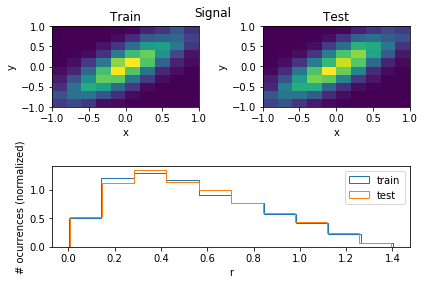

In [34]:
fig=plt.figure()
fig.suptitle('Signal')
ax1=fig.add_subplot(221)
ax1.hist2d(trnSX,trnSY)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222)
ax2.hist2d(tstSX,tstSY)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnSR,normed=1,histtype='step',label='train')
ax3.hist(tstSR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

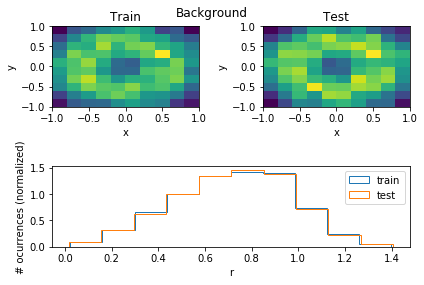

In [32]:
fig=plt.figure()
fig.suptitle('Background')
ax1=fig.add_subplot(221)
ax1.hist2d(trnBX,trnBY)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Train')
ax2=fig.add_subplot(222)
ax2.hist2d(tstBX,tstBY)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Test')
ax3=fig.add_subplot(212)
ax3.hist(trnBR,normed=1,histtype='step',label='train')
ax3.hist(tstBR,normed=1,histtype='step',label='test')
ax3.set_xlabel('r')
ax3.set_ylabel('# ocurrences (normalized)')
ax3.legend()
plt.tight_layout()

### Kolmogorov

In [38]:
#For radial distance
Skol = stat.ks_2samp(trnSR,tstSR)
Bkol = stat.ks_2samp(trnBR,tstBR)
print Skol
print Bkol

Ks_2sampResult(statistic=0.018600000000000005, pvalue=0.062138623199628297)
Ks_2sampResult(statistic=0.0093999999999999917, pvalue=0.76711145525773772)


Comment the cases for which the p-value is very low (i.e. p < 0.01).

## Part c

$$\int _{-1}^1\int _{-1}^1e^{-6 x^2+10 x y-6 y^2}dxdy=0.86787$$

$$\int_{Tcut}^\infty f_s(T)dT = \int re^{-r^2(6-10\cos\theta\sin\theta)} dr d\theta$$


In [79]:
def fs_polar(r,theta):
    cosa = 6-5*np.sin(2*theta)
    return r*np.exp(-r**2*cosa)/0.86787 #Divide by 0.86 to get normalized function   

def fs_xy_not_normed(y,x):
    cosa = -6*(x**2+y**2)+10*x*y
    return np.exp(cosa)

norm = pyint.dblquad(fs_xy_not_normed,-1,1,lambda x: -1,lambda x: 1)[0]

def fs_xy(y,x):
    cosa = -6*(x**2+y**2)+10*x*y
    return np.exp(cosa)/norm

In [100]:
print pyint.dblquad(fs_xy,-1,1,lambda x: -1,lambda x: 1) #The first output is 1, indicating that the function is properly normalized
N = 50
r1 = np.linspace(1e-6,1,N)
r2 = np.linspace(1,np.sqrt(2),N)
alpha1 = np.empty(N)
alpha2 = np.empty(N)
beta1 = np.empty(N)
beta2 = np.empty(N)
r0 = 0.6
sigmar = 0.4
int2zero = stat.norm.cdf(0,r0,sigmar)

for i,r in enumerate(r1):
    alpha1[i] =  1.-pyint.dblquad(fs_xy,-r,r,lambda x: -np.sqrt(r**2-x**2),lambda x: np.sqrt(r**2-x**2))[0]
    beta1[i] = stat.norm.cdf(r,r0,sigmar)-int2zero

for i,r in enumerate(r2):
    plus_quadrant = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: np.sqrt(r**2-x**2),lambda x: 1)[0]
    minus_quadrant = 2.*pyint.dblquad(fs_xy,np.sqrt(r**2-1),1,lambda x: -np.sqrt(r**2-x**2),lambda x: -1)[0]
    alpha2[i] =  plus_quadrant+minus_quadrant
    beta2[i] = stat.norm.cdf(r,r0,sigmar)-int2zero


(1.0, 1.2394915710084006e-08)


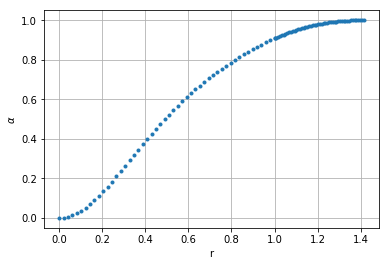

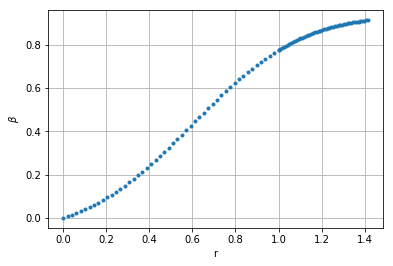

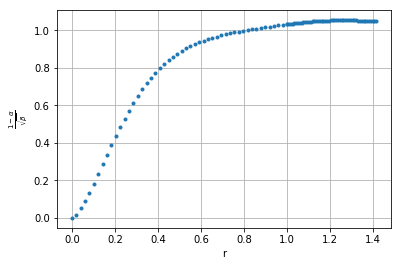

In [105]:
alpha = np.concatenate((alpha1,alpha2),axis=0)
beta = np.concatenate((beta1,beta2),axis=0)
r = np.concatenate((r1,r2),axis=0)
plt.plot(r,1-alpha,'.')
plt.xlabel('r')
plt.ylabel(r'$\alpha$')
plt.grid(True)
plt.figure()
plt.plot(r,beta,'.')
plt.xlabel('r')
plt.ylabel(r'$\beta$')
plt.grid(True)
plt.figure()
plt.plot(r,(1-alpha)/np.sqrt(beta),'.')
plt.xlabel('r')
plt.ylabel(r'$\frac{1-\alpha}{\sqrt{\beta}}$')
plt.grid(True)

#### a.2) Fischer discriminant

In [16]:
trainSignalTheta = np.arctan(trainSignalY/trainSignalX)
trainBkgTheta = np.arctan(trainBkgY/trainBkgX)
def Fischer_a2(sample,a):
    T = np.dot(a,sample)
    return T

C:\Users\Oriol\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
